# **My RNN notes**

**Recurrent Neural Network (RNN)**: Able to take different amounts of input values to make a prediction (# of inputs doesn’t have to be fixed)
similar to other neural networks with weights, biases, layers, and activation functions

**Feedback loops**: Only difference RNN has from other neural networks. Feedback loops allow for past sequential input values to affect current predictions.
* Same weights & biases are used for different time data that is inputted into a feed-forward iteration
* Weights and biases are changed only during backpropagation.

## Steps
Format values as (yesterday, today, tomorrow)

Ex: Given (0,0,0). Input = yesterday’s & today’s value. Expected output = tomorrow's value

1. Plug yesterday’s value into network. Do a forward-pass. Ex:
2. Today’s prediction = ReLU[(0*1.8)+0] * 1.1+0 = 0 * 1.1 + 0 = 0
3. Plug yesterday’s value into network. Do a forward-pass on same network but stop at summation.
4. Must sum (today*w1) + (yesterday’s ReLU[(0*1.8)+0] * w2)
* ReLU[(0 * 1.8) + 0 + 0)] = 0
* Tomorrow’s prediction = 0*1.1+0 = 0+0 = 0

## Backpropagation step
Find gradients for each weight/bias
Plug gradients into gradient descent algorithm to find weight/bias value that minimizes loss function.
RNN can use sum of squared residuals as Loss function bc it can use the actual yesterday value as y & its predicted yesterday value as ŷ

## RNN weaknesses

Difficult to train if there are a lot of feedback loops (because there are too much past data that is being plugged in to predict 1 output)
### exploding gradient
**Exploding gradient**: Feedback loop’s weight (w2) is too big (bigger than 1) and past sequential data has too much influence on the prediction of future value.

Ex: w2 = 5
1. If we do feedforward, yesterday’s value will be plugged in, so ReLU(input * 5 + bias)
2. That output plugged into another feedback loop will increase five-fold again, so ReLU(ReLU(input * 5 + bias) + today’s value)
3. That output plugged into another feedback loop will increase five-fold again,
4. and so on… Repeatedly growing at a rate of 5n for each feedback loop where n = total # of past sequential datapoints that are being entered as input for prediction

Because we’ll use this value for backpropagation, it’ll end up affecting weight changes too drastically & cause too big of steps to be taken in gradient descent, which may end up jumping over optimal weight/bias values.

#### vanishing gradient
**Vanishing gradient**: Feedback loop’s weight (w2) is too small (smaller than 1) and past sequential data has too little influence on the prediction of future value.
* just like exploding gradient problem except this time, it is decreasing by 0.5n where n = total # of past sequential datapoints that are being entered as input for prediction




# **My LSTM notes**
**Long Short Term Memory (LSTM)**: Uses 2 seperate paths (long term memory path & short term memory path) to make predictions about future values
instead of using ReLU like in RNN, LSTMs usually use sigmoid() & tanh() as activation functions
### **Sigmoid()**: Used in LSTM to calculate % of influence long/short term memory should have on predictions
* When input is small & negative, sigmoid(input) = close to 0
* When input is big & positive, sigmoid(input) = close to 1

### **Tanh()**: Used in LSTM to calculate new long/short term memories
* When input is small & negative, tanh(input) = close to -1
* When input is big & positive, tanh(input) = close to 1

## Long term memory path
**Cell state**: Input can NOT be changed by any weights or biases. It can only be affected by 2 things:
* Multiplication by a short term memory value
* Sum by another short term memory value

## Short term memory path
**hidden state**: Short term memories have weights & biases that can influence input values.
* **Forget gate**: 1st gate. Determines how much should be remembered. How much influence should long-term memory have on prediction? If…
forget gate output = 0, forget the long term memory (it’s multiplied by 0 so it zeroes out)
forget gate output = 1, remember the long term memory (it’s multiplied by 1 so it stays the same)
* **Input gate**: Create the next potential long term memory.
> * Tanh() part - Creates new potential long term memory
> * Sigmoid() part - Same as for previous step when calculating long term memory’s influence except this is for calculating new long term memory’s influence
* **Output gate**: Create new short term memory
> * Tanh() part - New short term memory = tanh(calculated new long term memory)
> * Sigmoid() part - calculating new short term memory’s influence

## Steps

Ex: Assume previous long term memory = 2, previous short term memory = 1, and input = 1.

1. Start on hidden state, forget gate: sigmoid((1 * 2.7) + (1 * 1.63) + 1.62) = 0.9974
2. 0.9974 is the amount of influence we decide the long-term memory should continue to have on next prediction
3. Cell state: Multiply by 0.9974: 2 * 0.9974 = 1.9948
4. Go to hidden state, input gate layer:  
> * tanh((1 * 1.41) + (1 * 0.94) - 0.32) = 0.966
> * sigmoid((1 * 2) + (1 * 1.65) + 0.62) = 0.986
> * Multiply them together 0.966 * 0.986 = 0.952
5. Cell state: Sum by  1.9948 + 0.952 = 2.9468
6. So new long term memory = 2.9468
7. Go to hidden state, output gate layer:
> * tanh(2.9468) = 0.99
> * sigmoid((1 * 4.38) + (1 * 0.19) + 0.59) = 0.99
8. New short term memory = 0.99 * 0.99 = 0.98


# **Installs & imports**

In [1]:
!pip install scipy --upgrade -q

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy import signal
from scipy.integrate import trapezoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **Preprocess data**

In [3]:
def get_sampling_frequency(filepath: str, verbose: bool = False) -> float:
    sampling_frequency = 0 # default sampling frequency
    with h5py.File(filepath, "r") as file:
        sampling_frequency = file.attrs["fs"][0]
        if verbose:
            print(f"Sampling rate: {sampling_frequency} Hz")
    return sampling_frequency

def split_NREM_and_WAKE(filepath: str, verbose: bool = False) -> tuple:
    states = []
    with h5py.File(filepath, "r") as file:
        for name, group in file.items():
            states.append(name)
            if name == "NREM":
                NREM = list(group.keys())
            elif name == "WAKE":
                WAKE = list(group.keys())
            if verbose:
                print(f"State: {name}")
                # Under each h5 group, the LFP recordings are divided into several segments with different lengths.
                print(f"Segment IDs: {list(group.keys())}")
    return NREM, WAKE

def get_values_in_np_array(filepath: str, lfp: dict, verbose: bool = False) -> list:
    with h5py.File(filepath, "r") as file:
        for name, group in file.items():
            values = []
            for i in range(len(group)):
                values.append(group[str(i+1)][()].astype(float))

            lfp[name] = values # Add a list of numpy arrays of all segments to dictionary
            if verbose:
                print(f"State: {name}")
                print(f"values: {values}")
    return lfp

def plot_state_at_segment_num(state: str, segment_num: int, sampling_frequency:float, lfp: dict):
    x = lfp[state][segment_num]  # accessing the segment_num-th LFP segment in NREM state (THIS IS 0-based counting!!!!)
    t = np.arange(x.size)/sampling_frequency  # time points
    plt.plot(t,x)
    plt.xlabel("seconds")
    plt.ylabel("amplitude")
    plt.show()

def resplit_data_by_sec(seconds: int, sampling_frequency: float, lfp: dict, verbose: bool = False) -> dict:
    aggregated_segments = {}
    resplitted_segments = {}
    clip_length = int(seconds * sampling_frequency)
    for state in lfp:
        aggregated_segments[state] = np.concatenate(lfp[state])

    for state, signal in aggregated_segments.items():
        aggregated_segments[state] = np.concatenate(lfp[state])

        # Calculate the maximum number of full segments that can fit
        new_segments_count = len(aggregated_segments[state]) // clip_length

        # Trim the signal to fit the exact number of full segments
        trimmed_signal = aggregated_segments[state][:new_segments_count * clip_length]

        # Reshape the trimmed signal
        resplitted_segments[state] = trimmed_signal.reshape(new_segments_count, clip_length)
        if verbose:
            print(f"State = {state}\nSegments = {resplitted_segments[state]}")
    return resplitted_segments


In [4]:
def preprocess_data(filepath: str, seconds: int = 5, verbose: bool = False) -> dict:
    sampling_frequency = get_sampling_frequency(filepath, verbose)  # Number of data points collected per second
    NREM, WAKE = split_NREM_and_WAKE(filepath, verbose)
    lfp = {"NREM": NREM, "WAKE": WAKE}
    lfp = get_values_in_np_array(filepath, lfp, verbose=verbose)
    print("THIS IS ORIGINAL PLOT at 0th segment")
    plot_state_at_segment_num("NREM", 0, sampling_frequency, lfp)
    resplitted_segments = resplit_data_by_sec(5, sampling_frequency, lfp, verbose=verbose)
    print("\n\nTHIS IS RESPLITTED PLOT at 0th segment")
    plot_state_at_segment_num("NREM", 10, sampling_frequency, resplitted_segments)
    return resplitted_segments

Sampling rate: 1000.0 Hz
State: NREM
Segment IDs: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']
State: WAKE
Segment IDs: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9']
State: NREM
values: [array([ -38.,   -4.,   45., ..., -348., -355., -312.]), array([-873., -859., -877., ..., 1338., 1242., 1210.]), array([-793., -771., -809., ...,  410.,  437.,  388.]), array([-143., -143., -106., ..., -257., -279., -250.]), array([ 872.,  846.,  867., ..., -373., -324., -378.]), array([ 292.,  190.,  147., ..., -885., -787., -687.]), array([ 87.,  27.,  15., ...,  13., -87., -83.]), array([149., 174.,  66., ..., 520., 553., 513.]), array([-1077., -1100.,  -963., ...,   337.,   247.,   300.]), array([ 77.,  77., 278., ..., 469., 424., 438.]), array([-192., -224., -291., ..., -743., -850., -876.]), array([1316., 1213., 1178., ...,   37.,   27.,  -68.]), array([  131.,

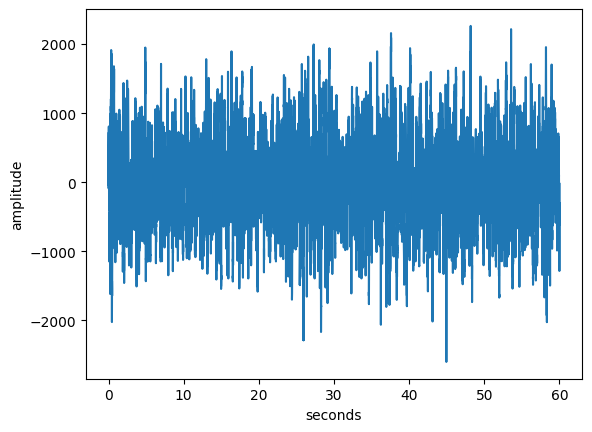

State = NREM
Segments = [[  -38.    -4.    45. ...  -121.   -68.   -25.]
 [ -197.   -89.  -189. ...   351.   362.   337.]
 [  347.   343.   237. ...  -634.  -622.  -455.]
 ...
 [  194.   130.    72. ...  -476.  -432.  -483.]
 [ -492.  -439.  -424. ...  -937.  -974.  -986.]
 [-1064. -1156. -1213. ...  -693.  -608.  -547.]]
State = WAKE
Segments = [[ -101.  -244.  -367. ...  -350.  -358.  -227.]
 [ -269.  -246.   -89. ...   132.   302.   284.]
 [  244.    68.   -94. ...  -732. -1054.  -906.]
 ...
 [  537.   396.   336. ...   -56.  -145.   220.]
 [   81.    81.    97. ...   583.   650.   284.]
 [  209.   612.   261. ...   209.   121.    10.]]


THIS IS RESPLITTED PLOT at 0th segment


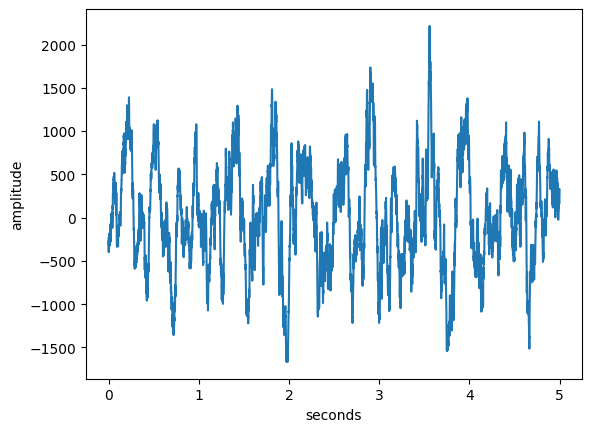

In [48]:
filename = "Part2SubjectHB13.h5" # Switch to Part1SubjectHB10.h5, Part2SubjectHB13.h5, or Rat08-20130711_017 then rerun entire notebook to see different model performances on different data
resplitted_segments = preprocess_data(filename, 5, True)
sampling_frequency = get_sampling_frequency(filename, False)

# **Design model inputs**


In [49]:
def min_max_normalization(data, new_min=0, new_max=1):
    # Calculate the min and max of the data
    old_min = np.min(data)
    old_max = np.max(data)

    # Apply min-max normalization
    normalized_data = (data - old_min) / (old_max - old_min)
    # Scale to the desired range [new_min, new_max]
    normalized_data = normalized_data * (new_max - new_min) + new_min

    return normalized_data

def get_psd(segment: np.ndarray, sampling_frequency: float):
    segment_length = int(sampling_frequency * len(segment))
    power_features = {}
    frequencies, psd = signal.welch(segment, fs=sampling_frequency, nperseg=1024)
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "beta": (12, 30),
        "gamma": (30, 100)
    }
    for band_name, (low_freq, high_freq) in bands.items():
        band_mask = (frequencies >= low_freq) & (frequencies <= high_freq)

        # Compute the band power by integrating (summing) the PSD values in the frequency band
        band_power = trapezoid(psd[band_mask], frequencies[band_mask])
        power_features[band_name + '_power'] = band_power
    return psd, power_features

def dict_to_dataframe(resplitted_segments: dict, sampling_frequency: float, normalization: bool=False):
    data = []
    for state, values in resplitted_segments.items():
        for segment in values:
            if normalization:
                segment = min_max_normalization(segment)
            psd, power_features = get_psd(segment, sampling_frequency)
            row = {"State": state,
             "Avg": np.mean(segment),
             "Standard deviation": np.std(segment),
             "Skewness": skew(segment, axis=0, bias=True),
             "Kurtosis": kurtosis(segment, axis=0, bias=True),
            }
            row.update(power_features)
            data.append(row)

    return pd.DataFrame(data)

In [50]:
original_dataframe = dict_to_dataframe(resplitted_segments, sampling_frequency)
original_dataframe

,State,Avg,Standard deviation,Skewness,Kurtosis,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,NREM,8.3246,648.625538,0.213447,0.267218,168613.182235,101889.816155,33205.148350,30990.525576,12018.726306
1,NREM,-23.7264,490.353023,0.030549,-0.253968,48003.983900,81593.109070,24286.444166,19112.260015,8542.927892
2,NREM,-1.3200,574.885994,0.157236,-0.349265,142204.724049,33607.315391,31614.990910,26144.651904,10685.594737
3,NREM,-5.2282,576.353238,0.138951,0.115432,106976.305516,76767.924463,40075.353833,38661.820350,13058.452324
4,NREM,15.5694,554.957157,-0.097141,-0.307963,99735.072123,66597.586213,29746.475904,26862.155643,9963.095976
...,...,...,...,...,...,...,...,...,...,...
909,WAKE,-6.3400,636.889207,0.022579,-0.109970,56491.883326,120163.015470,15804.627955,67399.150576,60020.297868
910,WAKE,-3.7478,639.696699,0.183354,1.346380,106690.683595,103887.995996,29873.962147,56460.243995,45091.715994
911,WAKE,-1.8172,670.030548,0.168209,0.236662,162198.180966,54379.134167,26311.559641,66966.559134,33975.418440
912,WAKE,1.9850,595.487661,-0.131714,0.425177,142050.896353,36606.346994,18716.875324,53103.239537,31211.865898


In [51]:
normalized_dataframe = dict_to_dataframe(resplitted_segments, sampling_frequency, normalization=True)
normalized_dataframe

,State,Avg,Standard deviation,Skewness,Kurtosis,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,NREM,0.511411,0.163299,0.213447,0.267218,0.010687,0.006458,0.002105,0.001964,0.000762
1,NREM,0.432257,0.160298,0.030549,-0.253968,0.005130,0.008720,0.002595,0.002042,0.000913
2,NREM,0.463964,0.172898,0.157236,-0.349265,0.012863,0.003040,0.002860,0.002365,0.000967
3,NREM,0.453774,0.165762,0.138951,0.115432,0.008849,0.006350,0.003315,0.003198,0.001080
4,NREM,0.527398,0.170704,-0.097141,-0.307963,0.009437,0.006301,0.002815,0.002542,0.000943
...,...,...,...,...,...,...,...,...,...,...
909,WAKE,0.488958,0.145475,0.022579,-0.109970,0.002947,0.006269,0.000825,0.003516,0.003131
910,WAKE,0.407307,0.122196,0.183354,1.346380,0.003893,0.003791,0.001090,0.002060,0.001645
911,WAKE,0.452653,0.142378,0.168209,0.236662,0.007324,0.002455,0.001188,0.003024,0.001534
912,WAKE,0.569878,0.121677,-0.131714,0.425177,0.005931,0.001528,0.000781,0.002217,0.001303


In [52]:
normalized_dataframe.to_csv("Rat08-20130711_017_normalized_data_with_engineeried_features.csv", index=False)

# **Evaluation function for models**

In [53]:
def evaluate_model(model, X_test, y_test, verbose: bool = True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during evaluation
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()  # Convert probabilities to predictions (0 or 1)
        predicted = predicted.squeeze().cpu().numpy()  # Convert to NumPy array

    # Calculate metrics
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)

    if verbose:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# **Train models**

## RNN model

1. Prepare data for RNN model

In [54]:
dataframe = normalized_dataframe
X = dataframe[['Avg', 'Standard deviation', 'Skewness', 'Kurtosis', 'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].values
y = pd.get_dummies(dataframe['State'])["WAKE"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (samples, sequence_length=1, features=9)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # (samples, 1, 9)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure shape (batch_size, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure shape (batch_size, 1)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

2. Run RNN model

In [55]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)  # Get the output from the RNN (output, hidden state)
        out = out[:, -1, :]  # Use the last time step's output (you can also use average over time steps)
        out = F.relu(self.fc1(out)) # fully connected layer
        out = torch.sigmoid(self.fc2(out))  # Use sigmoid for binary classification
        return out

input_size = X_train.shape[2]
hidden_size = 64
RNN_layers = 2
batch_size =32
model = RNN(input_size, hidden_size, RNN_layers)

criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 40 # CNN had to have 70
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/40], Loss: 0.5220
Epoch [2/40], Loss: 0.1928
Epoch [3/40], Loss: 0.1410
Epoch [4/40], Loss: 0.1381
Epoch [5/40], Loss: 0.1345
Epoch [6/40], Loss: 0.1326
Epoch [7/40], Loss: 0.1276
Epoch [8/40], Loss: 0.1317
Epoch [9/40], Loss: 0.1239
Epoch [10/40], Loss: 0.1195
Epoch [11/40], Loss: 0.1235
Epoch [12/40], Loss: 0.1132
Epoch [13/40], Loss: 0.1122
Epoch [14/40], Loss: 0.1113
Epoch [15/40], Loss: 0.1192
Epoch [16/40], Loss: 0.1145
Epoch [17/40], Loss: 0.1138
Epoch [18/40], Loss: 0.1047
Epoch [19/40], Loss: 0.1061
Epoch [20/40], Loss: 0.1050
Epoch [21/40], Loss: 0.1051
Epoch [22/40], Loss: 0.1027
Epoch [23/40], Loss: 0.1052
Epoch [24/40], Loss: 0.0996
Epoch [25/40], Loss: 0.1032
Epoch [26/40], Loss: 0.1047
Epoch [27/40], Loss: 0.0963
Epoch [28/40], Loss: 0.1010
Epoch [29/40], Loss: 0.1009
Epoch [30/40], Loss: 0.0980
Epoch [31/40], Loss: 0.0940
Epoch [32/40], Loss: 0.0919
Epoch [33/40], Loss: 0.0984
Epoch [34/40], Loss: 0.0966
Epoch [35/40], Loss: 0.0938
Epoch [36/40], Loss: 0.0937
E

3. Evaluation

In [57]:
RNN_accuracy, RNN_precision, RNN_recall, RNN_f1 = evaluate_model(model, X_test, y_test, verbose=True)

Accuracy: 0.9399
Precision: 0.9667
Recall: 0.9431
F1-Score: 0.9547


## LSTM
1. Prepare data for LSTM model

In [43]:
dataframe = normalized_dataframe
X = dataframe[['Avg', 'Standard deviation', 'Skewness', 'Kurtosis', 'delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].values
y = pd.get_dummies(dataframe['State'])["WAKE"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (samples, sequence_length=1, features=9)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])  # (samples, 1, 9)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure shape (batch_size, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure shape (batch_size, 1)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

2. Run LSTM model

In [46]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x) # Get the last hidden state
        return torch.sigmoid(self.fc(h_n[-1])) # Sigmoid for binary classification
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
model = LSTM(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(batch_X).squeeze()  # Forward pass
        loss = criterion(outputs, batch_y.squeeze())  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.6675
Epoch [2/10], Loss: 0.5891
Epoch [3/10], Loss: 0.4915
Epoch [4/10], Loss: 0.3797
Epoch [5/10], Loss: 0.2819
Epoch [6/10], Loss: 0.2104
Epoch [7/10], Loss: 0.1602
Epoch [8/10], Loss: 0.1288
Epoch [9/10], Loss: 0.1050
Epoch [10/10], Loss: 0.0892


3. Evaluation

In [47]:
LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1 = evaluate_model(model, X_test, y_test, verbose=True)

Accuracy: 0.9780
Precision: 0.9828
Recall: 0.9828
F1-Score: 0.9828


# **Discussion & Conclusion**
## methods
RNN - input_size layers, by letting batch_first=True, we specify that input tensor shapes has to be (batch_size, sequence_length, input_size). The feedback loop is handled inside RNN cell. After RNN finishes processing the sequence, I feed it into 2 fully connected neural network layers. 1st layer uses ReLU() & 2nd layer uses Sigmoid() (sigmoid for binary classification)
* In RNN forward() - out = all hidden states over time, _ = final hidden state. `out = out[:,-1,:]` gets output of last time step


LSTM - 1 hidden layer with 64 hidden nodes. Sigmoid function applied to input & output "gates", and also when determining which past state can be "forgotten"/discarded from affecting current prediction. Tanh function applied at cell state updates when determining which states to "remember"/keep tanh used to calculate new long and short term memory. Finally, another Sigmoid layer at end of output layer to convert values to binary values (0 for NREM 0 or 1 for WAKE)


## **results**
### (for Part1SubjectHB10.h5)

RNN Accuracy: 0.9890

RNN Precision: 0.9831

RNN Recall: 1.0000

RNN F1-Score: 0.9915

LSTM Accuracy: 0.9780

LSTM Precision: 0.9828

LSTM Recall: 0.9828

LSTM F1-Score: 0.9828

### (for Part2SubjectHB13.h5)

RNN Accuracy: 0.9399

RNN Precision: 0.9667

RNN Recall: 0.9431

RNN F1-Score: 0.9547

LSTM Accuracy: 0.9290

LSTM Precision: 0.9911

LSTM Recall: 0.9024

LSTM F1-Score: 0.9447


### (for Rat08-20130711_017.h5)

RNN Accuracy: 0.9235

RNN Precision: 0.9499

RNN Recall: 0.9277

RNN F1-Score: 0.9386

LSTM Accuracy: 0.9208

LSTM Precision: 0.9497

LSTM Recall: 0.9234

LSTM F1-Score: 0.9364


## insights

Although the accuracy (correct classifications/total classifications) is high (~0.87), if entire Rat08 dataset is skewed towards NREM or WAKE then this metric is an inaccurate representation of model's actual performance.


---


Precision (correct positives / all correct & incorrect positives) when actual positives (actual WAKE states) is balanced/high in dataset. The score (~0.90) is high, meaning model makes accurate predicitions about if rat is in WAKE state.


---

Recall (correct positives / all real positives) when false negatives (NREM misclassified as WAKE) is more detrimental to classification task. The recall score (\~0.89) is similar to accuracy score (~0.87), which can be (not always) a sign that Rat08 dataset is relatively balanced.
* But because we don't know what this classification of rat states are for, we can't be sure if recall score is useful
* ~89% of NREM were able to be classified by model which is relatively good and an indicator that model isn't overfitting.

---

F1-score is a combination of recall & precision metrics without the inability to account for imbalanced datasets (as is the case for simple accuracy scores).
* Since we don't know if classification task would penalize incorrect NREMs or reward correct WAKE classification predictions more, f1-score can be a balance of both, assuming that both are equally important. CNN model with ~90% for f1 score is relatively good without the score being too high (which means it's overfitting)
